In [11]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from src.crimp import crimp

In [12]:
def simulate_sir_once(G, seeds, beta=0.03, gamma=0.1, max_steps=200, rng=None):
    """
    Discrete-time SIR simulation (synchronous updates).
    States: 0=S, 1=I, 2=R

    Returns:
        timeline: list of (S_count, I_count, R_count)
        final_R: final recovered count
        peak_I: peak infected count
    """
    if rng is None:
        rng = random.Random()

    state = {u: 0 for u in G.nodes()}
    for s in seeds:
        state[s] = 1

    timeline = []

    for _ in range(max_steps):
        S = sum(1 for u in state if state[u] == 0)
        I = sum(1 for u in state if state[u] == 1)
        R = sum(1 for u in state if state[u] == 2)
        timeline.append((S, I, R))

        if I == 0:
            break

        to_infect = set()
        to_recover = set()

        # Decide transitions based on current state (synchronous update)
        for u in G.nodes():
            if state[u] == 1:
                # Recovery
                if rng.random() < gamma:
                    to_recover.add(u)
                # Infection attempts to neighbors
                for v in G.neighbors(u):
                    if state[v] == 0:
                        if rng.random() < beta:
                            to_infect.add(v)

        for v in to_infect:
            state[v] = 1
        for u in to_recover:
            state[u] = 2

    final_R = timeline[-1][2]
    peak_I = max(x[1] for x in timeline)
    return timeline, final_R, peak_I


def simulate_sir(G, seeds, beta=0.03, gamma=0.1, max_steps=200, runs=200, seed=42):
    """
    Monte Carlo wrapper.
    Returns mean final recovered fraction and mean peak infected fraction.
    """
    rng = random.Random(seed)
    n = G.number_of_nodes()

    final_R_list = []
    peak_I_list = []

    for _ in range(runs):
        # Use independent RNG stream
        sub_rng = random.Random(rng.randint(0, 10**9))
        _, final_R, peak_I = simulate_sir_once(G, seeds, beta, gamma, max_steps, rng=sub_rng)
        final_R_list.append(final_R / n)
        peak_I_list.append(peak_I / n)

    return float(np.mean(final_R_list)), float(np.mean(peak_I_list))

In [13]:
def topk_from_scores(score_dict, k):
    return [n for n, _ in sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:k]]


def rank_crimp(G):
    res = crimp(G)
    return res.r_imp


def rank_degree(G):
    return {n: float(G.degree(n)) for n in G.nodes()}


def rank_betweenness(G):
    bc = nx.betweenness_centrality(G, normalized=True)
    return {n: float(bc[n]) for n in G.nodes()}


def rank_pagerank(G):
    pr = nx.pagerank(G)
    return {n: float(pr[n]) for n in G.nodes()}

In [14]:
G = nx.Graph()
edges = [
    (9,10), (9,11), (9,5),
    (5,2), (5,1),
    (1,2), (1,3), (2,3), (1,4), (2,4), (3,4),
    (4,12), (4,13), (4,14), (12,13),
    (3,8), (8,7), (7,6), (6,3)
]
G.add_edges_from(edges)

beta = 0.05
gamma = 0.10
runs = 300
k = 2  # number of seed nodes

rankers = {
    "CRimp": rank_crimp,
    "Degree": rank_degree,
    "Betweenness": rank_betweenness,
    "PageRank": rank_pagerank,
}

rows = []
for name, fn in rankers.items():
    scores = fn(G)
    seeds = topk_from_scores(scores, k)
    mean_final, mean_peak = simulate_sir(G, seeds, beta=beta, gamma=gamma, runs=runs, seed=123)
    rows.append({
        "method": name,
        "k": k,
        "beta": beta,
        "gamma": gamma,
        "runs": runs,
        "seeds": seeds,
        "mean_final_recovered": mean_final,
        "mean_peak_infected": mean_peak,
    })

df = pd.DataFrame(rows).sort_values("mean_final_recovered", ascending=False)
df

,method,k,beta,gamma,runs,seeds,mean_final_recovered,mean_peak_infected
0,CRimp,2,0.05,0.1,300,"[4, 3]",0.416905,0.274524
1,Degree,2,0.05,0.1,300,"[4, 3]",0.416905,0.274524
2,Betweenness,2,0.05,0.1,300,"[4, 3]",0.416905,0.274524
3,PageRank,2,0.05,0.1,300,"[4, 3]",0.416905,0.274524


In [15]:
beta = 0.05
gamma = 0.10
runs = 300

ks = [1, 2, 3, 4, 5]

out = []
for k in ks:
    for name, fn in rankers.items():
        scores = fn(G)
        seeds = topk_from_scores(scores, k)
        mean_final, mean_peak = simulate_sir(G, seeds, beta=beta, gamma=gamma, runs=runs, seed=100 + k)
        out.append([name, k, mean_final, mean_peak])

sir_df = pd.DataFrame(out, columns=["method", "k", "mean_final_recovered", "mean_peak_infected"])
sir_df

,method,k,mean_final_recovered,mean_peak_infected
0,CRimp,1,0.327857,0.219524
1,Degree,1,0.327857,0.219524
2,Betweenness,1,0.327857,0.219524
3,PageRank,1,0.327857,0.219524
4,CRimp,2,0.445714,0.285000
5,Degree,2,0.445714,0.285000
6,Betweenness,2,0.445714,0.285000
7,PageRank,2,0.445714,0.285000
8,CRimp,3,0.469762,0.314762
9,Degree,3,0.469762,0.314762


In [16]:
def get_seeds_for_all_ks(G, rankers, ks):
    rows = []
    for k in ks:
        for name, fn in rankers.items():
            scores = fn(G)
            seeds = topk_from_scores(scores, k)
            rows.append({"method": name, "k": k, "seeds": seeds})
    return pd.DataFrame(rows)

seed_df = get_seeds_for_all_ks(G, rankers, ks)
seed_df

,method,k,seeds
0,CRimp,1,[4]
1,Degree,1,[4]
2,Betweenness,1,[4]
3,PageRank,1,[4]
4,CRimp,2,"[4, 3]"
5,Degree,2,"[4, 3]"
6,Betweenness,2,"[4, 3]"
7,PageRank,2,"[4, 3]"
8,CRimp,3,"[4, 3, 2]"
9,Degree,3,"[4, 3, 2]"


In [17]:
G = nx.karate_club_graph()

beta = 0.03
gamma = 0.1
runs = 300

ks = [1, 2, 3, 4, 5, 10]  # or based on percentage later

out = []
for k in ks:
    for name, fn in rankers.items():
        scores = fn(G)
        seeds = topk_from_scores(scores, k)
        mean_final, mean_peak = simulate_sir(G, seeds, beta=beta, gamma=gamma, runs=runs, seed=100 + k)
        out.append([name, k, mean_final, mean_peak])

sir_df = pd.DataFrame(out, columns=["method", "k", "mean_final_recovered", "mean_peak_infected"])
sir_df

,method,k,mean_final_recovered,mean_peak_infected
0,CRimp,1,0.296471,0.145980
1,Degree,1,0.296471,0.145980
2,Betweenness,1,0.286569,0.146471
3,PageRank,1,0.296471,0.145980
4,CRimp,2,0.447059,0.229020
5,Degree,2,0.447059,0.229020
6,Betweenness,2,0.447059,0.229020
7,PageRank,2,0.447059,0.229020
8,CRimp,3,0.479020,0.245000
9,Degree,3,0.479020,0.245000


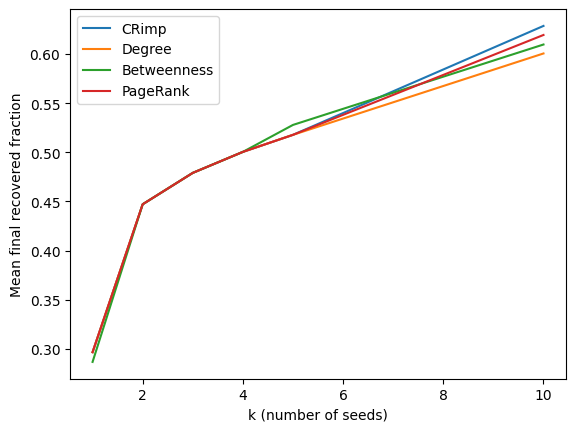

In [18]:
for method in sir_df["method"].unique():
    tmp = sir_df[sir_df["method"] == method].sort_values("k")
    plt.plot(tmp["k"], tmp["mean_final_recovered"], label=method)

plt.xlabel("k (number of seeds)")
plt.ylabel("Mean final recovered fraction")
plt.legend()
plt.show()